In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

In [3]:
def euler_Method(S0, interest_rate, delta_t, N, volatality):
    prev_S = S0
    stock_prices = [S0]
    for _ in range(1, N):
        Zm = norm.rvs()
        next_S = prev_S * ( 1 + interest_rate * delta_t + volatality * np.sqrt(delta_t) * Zm )
        prev_S = next_S
        stock_prices.append(next_S)
    return stock_prices

In [4]:
T = 1.0
K = 99
r = 0.06
S0 = 100 
sigma = 0.2
delta_t = 0.01
N = int(T/delta_t)


In [5]:
def priceOption(S0, r, delta_t, N, sigma, K, M, option_type = "call"):
    pay_offs = []
    for i in range(M):
        stock_price_N = (euler_Method(S0, r, delta_t, N, sigma))[-1]
        if option_type == "call":
            pay_off  = max(stock_price_N - K, 0)
        else:
            pay_off = max(K - stock_price_N, 0)
        pay_offs.append(pay_off)
    price_option = np.exp(-r*T) * np.mean(pay_offs)
    return price_option

In [9]:
m = []
option_values = []
for M in np.arange(100, 10000, 50):
    option_value = priceOption(S0, r, delta_t, N, sigma, K, M,"put")
    m.append(M)
    option_values.append(option_value)

Text(0, 0.5, 'Option value')

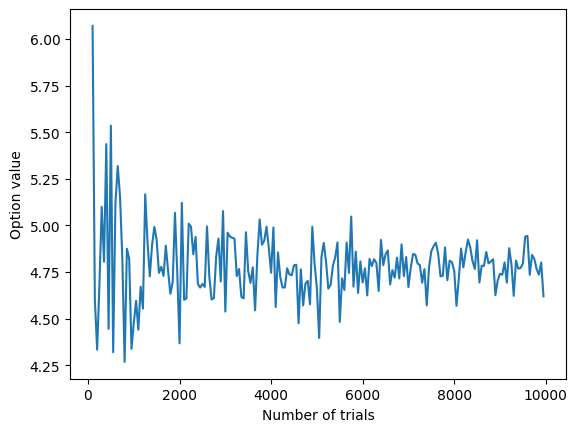

In [10]:
plt.plot(m, option_values)
plt.xlabel("Number of trials")
plt.ylabel("Option value")

In [15]:
## Varying strike price
K = np.arange(80, 120,2)
#volatality = 0.2
T = 1.0
r = 0.06
S0 = 100 
sigma = 0.2
delta_t = 0.001
M = 5000
N = int(T/delta_t)
option_values = []
for k in K:
    option_value = priceOption(S0, r, delta_t, N, sigma, k, M, "put")
    m.append(M)
    option_values.append(option_value)

Text(0, 0.5, 'Option Value')

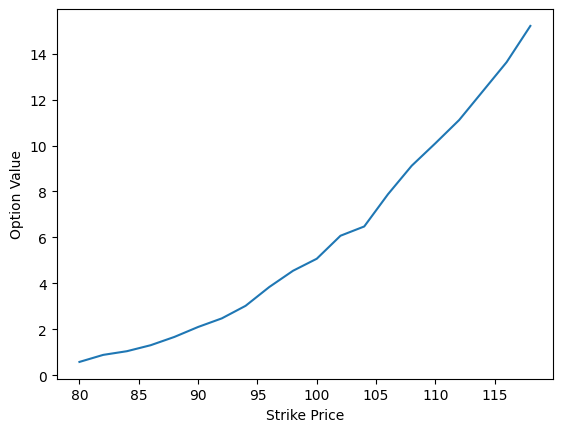

In [16]:
##Plotting the option values
plt.plot(K, option_values)
plt.xlabel("Strike Price")
plt.ylabel("Option Value")

In [13]:
### Varying volatality
vols = np.arange(0.1, 0.5, 0.01)
K = 99
T = 1.0
r = 0.06
S0 = 100 
sigma = 0.2
delta_t = 0.001
M = 5000
N = int(T/delta_t)
option_values = []
for vol in vols:
    option_value = priceOption(S0, r, delta_t, N, vol, K, M, "call")
    m.append(M)
    option_values.append(option_value)

Text(0, 0.5, 'Option Value')

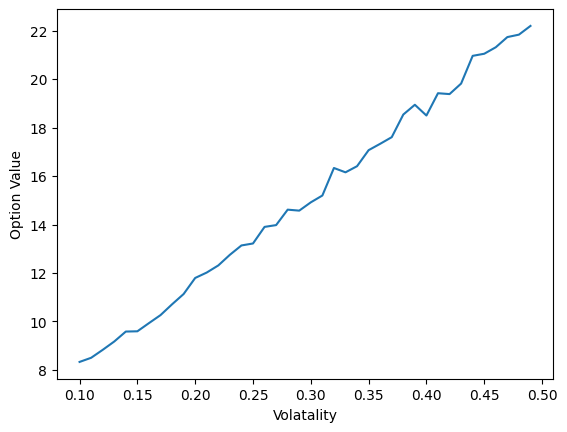

In [14]:
##Plotting the option values
plt.plot(vols, option_values)
plt.xlabel("Volatality")
plt.ylabel("Option Value")
